# Approach
1. Loading data
2. Impute Outliers with median data
3. Checking Correlation
4. Remove Negative Correlation variables
5. Splitting training and validating data
6. Prepare Test data
7. Feature Scaling
8. Model making
- - Logistic regression
- - KNN
- - RandomForestClassifier
- - XGBoost
- - Softmax
9. Cross-validation with `GridSearchCV`
10. Submit predictions of best models

In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

plt.style.use("ggplot")
sns.set_style("darkgrid")

## 1. Loading data

In [2]:
data = pd.read_csv("./data/preprocessed_data.csv")
test_data = pd.read_csv("./data/test.csv")

## 2. Checking Outliers

In [3]:
data.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,...,Cabin_deck_B,Cabin_deck_C,Cabin_deck_D,Cabin_deck_E,Cabin_deck_F,Cabin_deck_G,Cabin_deck_T,Cabin_side_P,Cabin_side_S,Transported
0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,0,1,...,1,0,0,0,0,0,0,1,0,0
1,0,24.0,0,109.0,9.0,25.0,549.0,44.0,1,0,...,0,0,0,0,1,0,0,0,1,1
2,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,0,16.0,0,303.0,70.0,151.0,565.0,2.0,1,0,...,0,0,0,0,1,0,0,0,1,1


<AxesSubplot:xlabel='Expenses', ylabel='Age'>

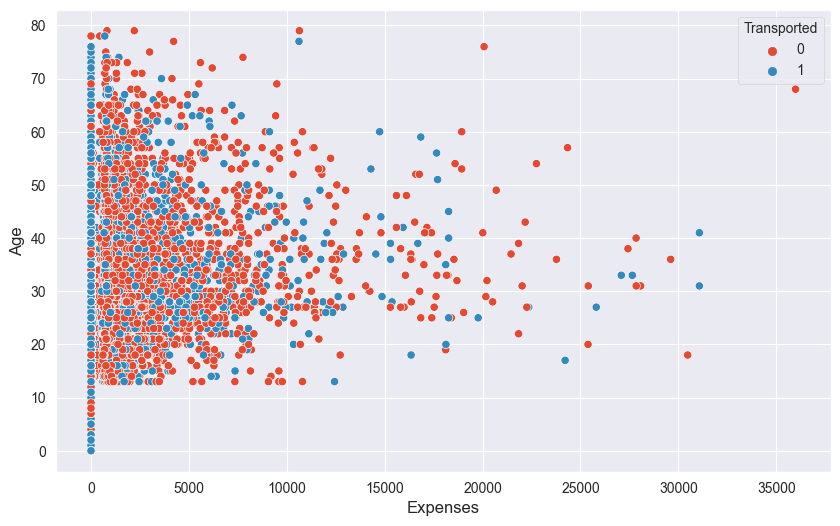

In [4]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Expenses", y="Age", data=data, hue="Transported")

<AxesSubplot:xlabel='Transported', ylabel='Age'>

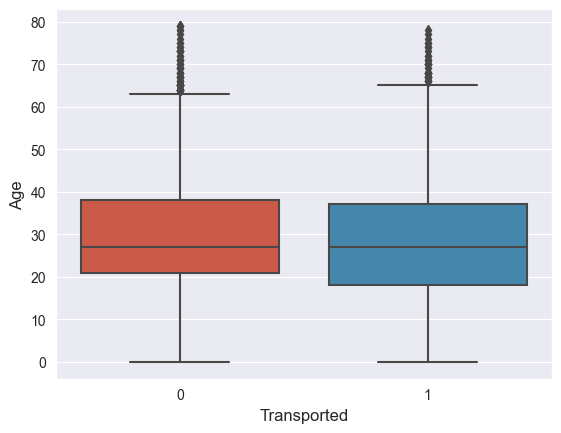

In [5]:
sns.boxplot(x=data["Transported"], y=data["Age"])

#### Outliers from data_cleaning IQR

In [6]:
false_age_outlier = 63.5
true_age_outlier = 65.5

In [7]:
data2 = data.copy(deep=True)

#### Imputing Outliers of Age on data2 with their Median Age

In [8]:
data2.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,...,Cabin_deck_B,Cabin_deck_C,Cabin_deck_D,Cabin_deck_E,Cabin_deck_F,Cabin_deck_G,Cabin_deck_T,Cabin_side_P,Cabin_side_S,Transported
0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,0,1,...,1,0,0,0,0,0,0,1,0,0
1,0,24.0,0,109.0,9.0,25.0,549.0,44.0,1,0,...,0,0,0,0,1,0,0,0,1,1
2,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,0,16.0,0,303.0,70.0,151.0,565.0,2.0,1,0,...,0,0,0,0,1,0,0,0,1,1


In [9]:
false_age_filter = (data2["Age"] > false_age_outlier) & (data2["Transported"]==0)
ind_false_age_outlier = data2[false_age_filter].index
ind_false_age_outlier

Int64Index([ 280,  338,  469,  548,  615,  703,  705,  712,  718,  901, 1157,
            1335, 1356, 1390, 1429, 1603, 1607, 1655, 1686, 1734, 1923, 2137,
            2290, 2310, 2361, 2694, 2790, 2822, 2857, 2865, 2884, 3021, 3053,
            3171, 3184, 3526, 3562, 3632, 3971, 4310, 4433, 4657, 4682, 4803,
            5079, 5218, 5242, 5722, 5955, 5958, 6067, 6469, 6582, 6601, 6783,
            7012, 7013, 7038, 7224, 7289, 7387, 7501, 7576, 7584, 7715, 7729,
            7791, 7934, 8042, 8170, 8254, 8369, 8516],
           dtype='int64')

In [10]:
true_age_filter = (data2["Age"] > true_age_outlier) & (data2["Transported"]==1)
ind_true_age_outlier = data2[true_age_filter].index
ind_true_age_outlier

Int64Index([ 118,  378,  416,  779,  848,  917, 1267, 1379, 1714, 2006, 2159,
            2261, 2351, 2484, 2530, 2736, 2786, 2930, 2941, 3104, 3169, 3181,
            3280, 3540, 3930, 4132, 4349, 4934, 5267, 5315, 5353, 6146, 6200,
            6301, 6330, 6451, 7129, 7269, 7330, 8288],
           dtype='int64')

In [11]:
data2["Age"].median()

27.0

In [12]:
data2.loc[ind_false_age_outlier, "Age"] = data2["Age"].median()

In [13]:
data2.loc[ind_false_age_outlier, "Age"]

280     27.0
338     27.0
469     27.0
548     27.0
615     27.0
        ... 
8042    27.0
8170    27.0
8254    27.0
8369    27.0
8516    27.0
Name: Age, Length: 73, dtype: float64

In [14]:
data2.loc[ind_true_age_outlier, "Age"] = data2["Age"].median()
data2.loc[ind_false_age_outlier, "Age"]

280     27.0
338     27.0
469     27.0
548     27.0
615     27.0
        ... 
8042    27.0
8170    27.0
8254    27.0
8369    27.0
8516    27.0
Name: Age, Length: 73, dtype: float64

In [15]:
data2["Age"].max()

65.0

<AxesSubplot:xlabel='Transported', ylabel='Age'>

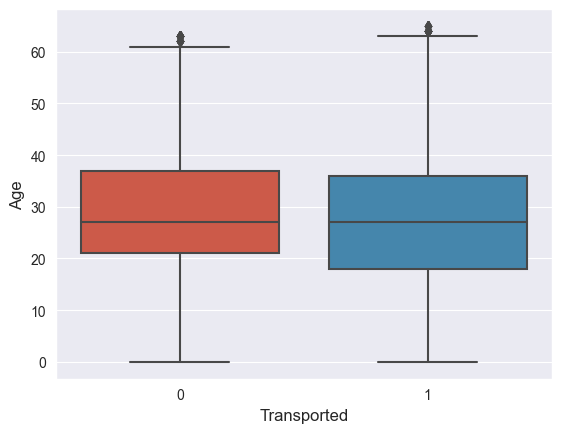

In [16]:
sns.boxplot(x=data2["Transported"], y=data2["Age"])

## 3. Checking correlation

In [17]:
preprocessed_data = pd.read_csv("./data/cleaned_data.csv")
preprocessed_data.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,0,B/0/P,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,False
1,Earth,0,F/0/S,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,True
2,Europa,0,A/0/S,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,0,A/0/S,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,0,F/1/S,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,True


<AxesSubplot:>

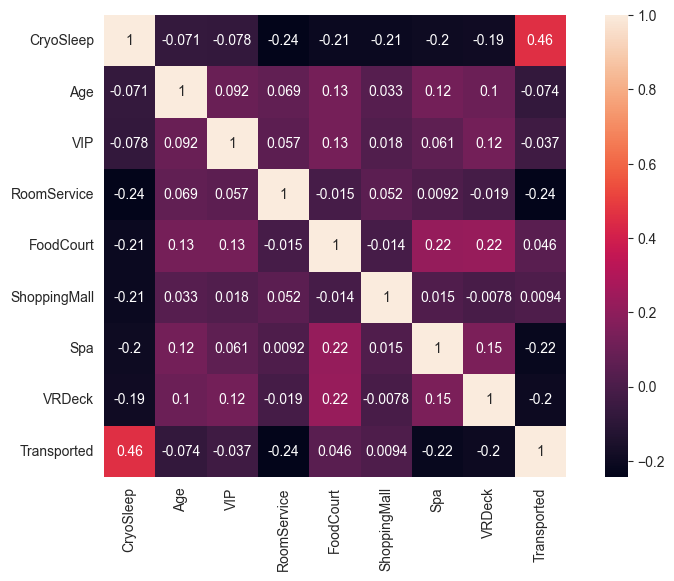

In [18]:
plt.figure(figsize=(10, 6))
sns.heatmap(preprocessed_data.corr(), annot=True, square=True)

## 4. Removing negative correlated features
- `RoomService`
- `Spa`
- `VRDeck`

In [19]:
pd.set_option("display.max_columns", data2.shape[1])
data2.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Cabin_num,Expenses,Cabin_deck_A,Cabin_deck_B,Cabin_deck_C,Cabin_deck_D,Cabin_deck_E,Cabin_deck_F,Cabin_deck_G,Cabin_deck_T,Cabin_side_P,Cabin_side_S,Transported
0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,1,0,0.0,0,1,0,0,0,0,0,0,1,0,0
1,0,24.0,0,109.0,9.0,25.0,549.0,44.0,1,0,0,0,0,1,0,736.0,0,0,0,0,0,1,0,0,0,1,1
2,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,1,0,0,0,1,0,10383.0,1,0,0,0,0,0,0,0,0,1,0
3,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,1,0,0,0,1,0,5176.0,1,0,0,0,0,0,0,0,0,1,0
4,0,16.0,0,303.0,70.0,151.0,565.0,2.0,1,0,0,0,0,1,1,1091.0,0,0,0,0,0,1,0,0,0,1,1


In [20]:
neg_cols = ["RoomService", "Spa", "VRDeck"]
data2.drop(columns=neg_cols, inplace=True)

In [21]:
data2.head()

,CryoSleep,Age,VIP,FoodCourt,ShoppingMall,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Cabin_num,Expenses,Cabin_deck_A,Cabin_deck_B,Cabin_deck_C,Cabin_deck_D,Cabin_deck_E,Cabin_deck_F,Cabin_deck_G,Cabin_deck_T,Cabin_side_P,Cabin_side_S,Transported
0,0,39.0,0,0.0,0.0,0,1,0,0,0,1,0,0.0,0,1,0,0,0,0,0,0,1,0,0
1,0,24.0,0,9.0,25.0,1,0,0,0,0,1,0,736.0,0,0,0,0,0,1,0,0,0,1,1
2,0,58.0,1,3576.0,0.0,0,1,0,0,0,1,0,10383.0,1,0,0,0,0,0,0,0,0,1,0
3,0,33.0,0,1283.0,371.0,0,1,0,0,0,1,0,5176.0,1,0,0,0,0,0,0,0,0,1,0
4,0,16.0,0,70.0,151.0,1,0,0,0,0,1,1,1091.0,0,0,0,0,0,1,0,0,0,1,1


### Calculating `Expenses` again based on `FoodCourt` and `ShoppingMall`

In [22]:
data2["Expenses"] = data2[["FoodCourt", "ShoppingMall"]].sum(axis=1)
data2.head()

,CryoSleep,Age,VIP,FoodCourt,ShoppingMall,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Cabin_num,Expenses,Cabin_deck_A,Cabin_deck_B,Cabin_deck_C,Cabin_deck_D,Cabin_deck_E,Cabin_deck_F,Cabin_deck_G,Cabin_deck_T,Cabin_side_P,Cabin_side_S,Transported
0,0,39.0,0,0.0,0.0,0,1,0,0,0,1,0,0.0,0,1,0,0,0,0,0,0,1,0,0
1,0,24.0,0,9.0,25.0,1,0,0,0,0,1,0,34.0,0,0,0,0,0,1,0,0,0,1,1
2,0,58.0,1,3576.0,0.0,0,1,0,0,0,1,0,3576.0,1,0,0,0,0,0,0,0,0,1,0
3,0,33.0,0,1283.0,371.0,0,1,0,0,0,1,0,1654.0,1,0,0,0,0,0,0,0,0,1,0
4,0,16.0,0,70.0,151.0,1,0,0,0,0,1,1,221.0,0,0,0,0,0,1,0,0,0,1,1


## 5. Splitting training and validation set

In [23]:
X = data2.iloc[:, :-1]
Y = data2.iloc[:, -1]
X.head()

,CryoSleep,Age,VIP,FoodCourt,ShoppingMall,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Cabin_num,Expenses,Cabin_deck_A,Cabin_deck_B,Cabin_deck_C,Cabin_deck_D,Cabin_deck_E,Cabin_deck_F,Cabin_deck_G,Cabin_deck_T,Cabin_side_P,Cabin_side_S
0,0,39.0,0,0.0,0.0,0,1,0,0,0,1,0,0.0,0,1,0,0,0,0,0,0,1,0
1,0,24.0,0,9.0,25.0,1,0,0,0,0,1,0,34.0,0,0,0,0,0,1,0,0,0,1
2,0,58.0,1,3576.0,0.0,0,1,0,0,0,1,0,3576.0,1,0,0,0,0,0,0,0,0,1
3,0,33.0,0,1283.0,371.0,0,1,0,0,0,1,0,1654.0,1,0,0,0,0,0,0,0,0,1
4,0,16.0,0,70.0,151.0,1,0,0,0,0,1,1,221.0,0,0,0,0,0,1,0,0,0,1


In [24]:
Y.head()

0    0
1    1
2    0
3    0
4    1
Name: Transported, dtype: int64

In [25]:
cols = X.columns
cols

Index(['CryoSleep', 'Age', 'VIP', 'FoodCourt', 'ShoppingMall',
       'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars',
       'Destination_55 Cancri e', 'Destination_PSO J318.5-22',
       'Destination_TRAPPIST-1e', 'Cabin_num', 'Expenses', 'Cabin_deck_A',
       'Cabin_deck_B', 'Cabin_deck_C', 'Cabin_deck_D', 'Cabin_deck_E',
       'Cabin_deck_F', 'Cabin_deck_G', 'Cabin_deck_T', 'Cabin_side_P',
       'Cabin_side_S'],
      dtype='object')

In [26]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2, random_state=0)

In [27]:
X_train.shape, y_train.shape

((6954, 23), (6954,))

In [28]:
X_valid.shape, y_valid.shape


((1739, 23), (1739,))

### 6. Transforming test data

In [29]:
test_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [30]:
index = test_data.pop("PassengerId")
test_data.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [31]:
test_data.isnull().sum()

HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

In [32]:
test_data["HomePlanet"].mode()

0    Earth
Name: HomePlanet, dtype: object

In [33]:
test_data["CryoSleep"].mode()

0    False
Name: CryoSleep, dtype: object

In [34]:
test_data["HomePlanet"].fillna("Earth", inplace=True)
test_data["CryoSleep"].fillna(False, inplace=True)

In [35]:
cabin_values = test_data["Cabin"].value_counts().head(20).index
cabin_values

Index(['G/160/P', 'D/273/S', 'B/31/P', 'G/748/S', 'E/228/S', 'A/4/S',
       'G/597/P', 'G/73/S', 'F/579/P', 'D/92/P', 'B/214/P', 'G/587/P',
       'C/31/S', 'C/177/S', 'B/72/S', 'B/242/P', 'G/737/S', 'G/591/P',
       'C/295/P', 'G/1052/P'],
      dtype='object')

In [36]:
test_data["Cabin"].fillna("missing", inplace=True)

In [37]:
test_data["Cabin"] = test_data["Cabin"].map(
    lambda x: random.choice(cabin_values) if x=="missing" else x
)

In [38]:
test_data["Cabin"].isnull().sum()

0

In [39]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    4277 non-null   object 
 1   CryoSleep     4277 non-null   bool   
 2   Cabin         4277 non-null   object 
 3   Destination   4185 non-null   object 
 4   Age           4186 non-null   float64
 5   VIP           4184 non-null   object 
 6   RoomService   4195 non-null   float64
 7   FoodCourt     4171 non-null   float64
 8   ShoppingMall  4179 non-null   float64
 9   Spa           4176 non-null   float64
 10  VRDeck        4197 non-null   float64
 11  Name          4183 non-null   object 
dtypes: bool(1), float64(6), object(5)
memory usage: 371.9+ KB


In [40]:
test_data["Destination"].mode()

0    TRAPPIST-1e
Name: Destination, dtype: object

In [41]:
test_data["Destination"].fillna("TRAPPIST-1e", inplace=True)

In [42]:
test_data["Age"].median()

26.0

In [43]:
test_data["Age"].fillna(26, inplace=True)

In [44]:
test_data["VIP"].mode()

0    False
Name: VIP, dtype: object

In [45]:
test_data["VIP"].fillna(False, inplace=True)

In [46]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    4277 non-null   object 
 1   CryoSleep     4277 non-null   bool   
 2   Cabin         4277 non-null   object 
 3   Destination   4277 non-null   object 
 4   Age           4277 non-null   float64
 5   VIP           4277 non-null   bool   
 6   RoomService   4195 non-null   float64
 7   FoodCourt     4171 non-null   float64
 8   ShoppingMall  4179 non-null   float64
 9   Spa           4176 non-null   float64
 10  VRDeck        4197 non-null   float64
 11  Name          4183 non-null   object 
dtypes: bool(2), float64(6), object(4)
memory usage: 342.6+ KB


In [47]:
test_data["RoomService"].mode()

0    0.0
Name: RoomService, dtype: float64

In [48]:
test_data["RoomService"].fillna(0, inplace=True)

In [49]:
test_data["FoodCourt"].mode()

0    0.0
Name: FoodCourt, dtype: float64

In [50]:
test_data["FoodCourt"].fillna(0, inplace=True)

In [51]:
test_data["ShoppingMall"].mode()

0    0.0
Name: ShoppingMall, dtype: float64

In [52]:
test_data["ShoppingMall"].fillna(0, inplace=True)

In [53]:
test_data["Spa"].mode()

0    0.0
Name: Spa, dtype: float64

In [54]:
test_data["Spa"].fillna(0, inplace=True)

In [55]:
test_data["VRDeck"].mode()

0    0.0
Name: VRDeck, dtype: float64

In [56]:
test_data["VRDeck"].fillna(0, inplace=True)

In [57]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    4277 non-null   object 
 1   CryoSleep     4277 non-null   bool   
 2   Cabin         4277 non-null   object 
 3   Destination   4277 non-null   object 
 4   Age           4277 non-null   float64
 5   VIP           4277 non-null   bool   
 6   RoomService   4277 non-null   float64
 7   FoodCourt     4277 non-null   float64
 8   ShoppingMall  4277 non-null   float64
 9   Spa           4277 non-null   float64
 10  VRDeck        4277 non-null   float64
 11  Name          4183 non-null   object 
dtypes: bool(2), float64(6), object(4)
memory usage: 342.6+ KB


In [58]:
test_data.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [59]:
test_data["CryoSleep"].replace({True:1, False:0}, inplace=True)

In [60]:
test_data.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,Earth,1,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,Earth,0,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,Europa,1,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,Europa,0,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,Earth,0,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [61]:
test_data["VIP"].replace({True:1, False:0}, inplace=True)

In [62]:
test_data.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,Earth,1,G/3/S,TRAPPIST-1e,27.0,0,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,Earth,0,F/4/S,TRAPPIST-1e,19.0,0,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,Europa,1,C/0/S,55 Cancri e,31.0,0,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,Europa,0,C/1/S,TRAPPIST-1e,38.0,0,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,Earth,0,F/5/S,TRAPPIST-1e,20.0,0,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [63]:
test_data["Expense"] = test_data[
    ["FoodCourt", "ShoppingMall"]
].sum(axis=1)

In [64]:
test_data[["Cabin_deck", "Cabin_num", "Cabin_side"]] = test_data["Cabin"].str.split("/", expand=True)
test_data.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Expense,Cabin_deck,Cabin_num,Cabin_side
0,Earth,1,G/3/S,TRAPPIST-1e,27.0,0,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,0.0,G,3,S
1,Earth,0,F/4/S,TRAPPIST-1e,19.0,0,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,9.0,F,4,S
2,Europa,1,C/0/S,55 Cancri e,31.0,0,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,0.0,C,0,S
3,Europa,0,C/1/S,TRAPPIST-1e,38.0,0,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,6652.0,C,1,S
4,Earth,0,F/5/S,TRAPPIST-1e,20.0,0,10.0,0.0,635.0,0.0,0.0,Brence Harperez,635.0,F,5,S


In [65]:
test_data["Cabin_num"] = test_data["Cabin_num"].astype(int)

In [66]:
home_planet_dummies = pd.get_dummies(test_data["HomePlanet"], prefix="HomePlanet")
test_data = test_data.join(home_planet_dummies)
test_data.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Expense,Cabin_deck,Cabin_num,Cabin_side,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars
0,Earth,1,G/3/S,TRAPPIST-1e,27.0,0,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,0.0,G,3,S,1,0,0
1,Earth,0,F/4/S,TRAPPIST-1e,19.0,0,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,9.0,F,4,S,1,0,0
2,Europa,1,C/0/S,55 Cancri e,31.0,0,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,0.0,C,0,S,0,1,0
3,Europa,0,C/1/S,TRAPPIST-1e,38.0,0,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,6652.0,C,1,S,0,1,0
4,Earth,0,F/5/S,TRAPPIST-1e,20.0,0,10.0,0.0,635.0,0.0,0.0,Brence Harperez,635.0,F,5,S,1,0,0


In [67]:
destination_dummies = pd.get_dummies(test_data["Destination"], prefix="Destination")
test_data = test_data.join(destination_dummies)
test_data.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Expense,Cabin_deck,Cabin_num,Cabin_side,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,Earth,1,G/3/S,TRAPPIST-1e,27.0,0,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,0.0,G,3,S,1,0,0,0,0,1
1,Earth,0,F/4/S,TRAPPIST-1e,19.0,0,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,9.0,F,4,S,1,0,0,0,0,1
2,Europa,1,C/0/S,55 Cancri e,31.0,0,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,0.0,C,0,S,0,1,0,1,0,0
3,Europa,0,C/1/S,TRAPPIST-1e,38.0,0,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,6652.0,C,1,S,0,1,0,0,0,1
4,Earth,0,F/5/S,TRAPPIST-1e,20.0,0,10.0,0.0,635.0,0.0,0.0,Brence Harperez,635.0,F,5,S,1,0,0,0,0,1


In [68]:
cabin_deck_dummies = pd.get_dummies(test_data["Cabin_deck"], prefix="Cabin_deck")
test_data = test_data.join(cabin_deck_dummies)
test_data.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Expense,...,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Cabin_deck_A,Cabin_deck_B,Cabin_deck_C,Cabin_deck_D,Cabin_deck_E,Cabin_deck_F,Cabin_deck_G,Cabin_deck_T
0,Earth,1,G/3/S,TRAPPIST-1e,27.0,0,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,0.0,...,0,0,0,0,1,0,0,0,0,0,0,1,0
1,Earth,0,F/4/S,TRAPPIST-1e,19.0,0,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,9.0,...,0,0,0,0,1,0,0,0,0,0,1,0,0
2,Europa,1,C/0/S,55 Cancri e,31.0,0,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,0.0,...,1,0,1,0,0,0,0,1,0,0,0,0,0
3,Europa,0,C/1/S,TRAPPIST-1e,38.0,0,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,6652.0,...,1,0,0,0,1,0,0,1,0,0,0,0,0
4,Earth,0,F/5/S,TRAPPIST-1e,20.0,0,10.0,0.0,635.0,0.0,0.0,Brence Harperez,635.0,...,0,0,0,0,1,0,0,0,0,0,1,0,0


In [69]:
cabin_side_dummies = pd.get_dummies(test_data["Cabin_side"], prefix="Cabin_side")
test_data = test_data.join(cabin_side_dummies)
test_data.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Expense,...,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Cabin_deck_A,Cabin_deck_B,Cabin_deck_C,Cabin_deck_D,Cabin_deck_E,Cabin_deck_F,Cabin_deck_G,Cabin_deck_T,Cabin_side_P,Cabin_side_S
0,Earth,1,G/3/S,TRAPPIST-1e,27.0,0,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,0.0,...,0,0,1,0,0,0,0,0,0,1,0,0,1
1,Earth,0,F/4/S,TRAPPIST-1e,19.0,0,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,9.0,...,0,0,1,0,0,0,0,0,1,0,0,0,1
2,Europa,1,C/0/S,55 Cancri e,31.0,0,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,0.0,...,1,0,0,0,0,1,0,0,0,0,0,0,1
3,Europa,0,C/1/S,TRAPPIST-1e,38.0,0,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,6652.0,...,0,0,1,0,0,1,0,0,0,0,0,0,1
4,Earth,0,F/5/S,TRAPPIST-1e,20.0,0,10.0,0.0,635.0,0.0,0.0,Brence Harperez,635.0,...,0,0,1,0,0,0,0,0,1,0,0,0,1


In [70]:
test_data.rename(columns={"Expense":"Expenses"}, inplace=True)

In [71]:
cols

Index(['CryoSleep', 'Age', 'VIP', 'FoodCourt', 'ShoppingMall',
       'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars',
       'Destination_55 Cancri e', 'Destination_PSO J318.5-22',
       'Destination_TRAPPIST-1e', 'Cabin_num', 'Expenses', 'Cabin_deck_A',
       'Cabin_deck_B', 'Cabin_deck_C', 'Cabin_deck_D', 'Cabin_deck_E',
       'Cabin_deck_F', 'Cabin_deck_G', 'Cabin_deck_T', 'Cabin_side_P',
       'Cabin_side_S'],
      dtype='object')

In [72]:
pd.set_option("display.max_columns", 30)
test_data = test_data[cols]
test_data

,CryoSleep,Age,VIP,FoodCourt,ShoppingMall,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Cabin_num,Expenses,Cabin_deck_A,Cabin_deck_B,Cabin_deck_C,Cabin_deck_D,Cabin_deck_E,Cabin_deck_F,Cabin_deck_G,Cabin_deck_T,Cabin_side_P,Cabin_side_S
0,1,27.0,0,0.0,0.0,1,0,0,0,0,1,3,0.0,0,0,0,0,0,0,1,0,0,1
1,0,19.0,0,9.0,0.0,1,0,0,0,0,1,4,9.0,0,0,0,0,0,1,0,0,0,1
2,1,31.0,0,0.0,0.0,0,1,0,1,0,0,0,0.0,0,0,1,0,0,0,0,0,0,1
3,0,38.0,0,6652.0,0.0,0,1,0,0,0,1,1,6652.0,0,0,1,0,0,0,0,0,0,1
4,0,20.0,0,0.0,635.0,1,0,0,0,0,1,5,635.0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,1,34.0,0,0.0,0.0,1,0,0,0,0,1,1496,0.0,0,0,0,0,0,0,1,0,0,1
4273,0,42.0,0,847.0,17.0,1,0,0,0,0,1,748,864.0,0,0,0,0,0,0,1,0,0,1
4274,1,26.0,0,0.0,0.0,0,0,1,1,0,0,296,0.0,0,0,0,1,0,0,0,0,1,0
4275,0,26.0,0,2680.0,0.0,0,1,0,0,0,1,297,2680.0,0,0,0,1,0,0,0,0,1,0


In [73]:
test_data.shape

(4277, 23)

In [74]:
X_train.shape

(6954, 23)

In [75]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  4277 non-null   int64  
 1   Age                        4277 non-null   float64
 2   VIP                        4277 non-null   int64  
 3   FoodCourt                  4277 non-null   float64
 4   ShoppingMall               4277 non-null   float64
 5   HomePlanet_Earth           4277 non-null   uint8  
 6   HomePlanet_Europa          4277 non-null   uint8  
 7   HomePlanet_Mars            4277 non-null   uint8  
 8   Destination_55 Cancri e    4277 non-null   uint8  
 9   Destination_PSO J318.5-22  4277 non-null   uint8  
 10  Destination_TRAPPIST-1e    4277 non-null   uint8  
 11  Cabin_num                  4277 non-null   int32  
 12  Expenses                   4277 non-null   float64
 13  Cabin_deck_A               4277 non-null   uint8

## 7. Scaling data using `StandardScaler`

In [76]:
scaler = StandardScaler()
scaled_columns = ["Age", "FoodCourt", "ShoppingMall", "Expenses", "Cabin_num"]
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

X_train[:5, :]

array([[-0.73173649,  1.88846818, -0.15296914,  0.07279194, -0.27768257,
        -1.09987433,  1.75254916, -0.51080794,  1.96370702, -0.31341858,
        -1.54453524, -0.8381773 , -0.03623946, -0.17989836, -0.31919523,
         3.1906213 , -0.2440828 , -0.3445662 , -0.69024135, -0.65617821,
        -0.02682402, -0.9879927 ,  0.9879927 ],
       [-0.73173649, -0.6113183 , -0.15296914, -0.27019708, -0.27610002,
         0.90919478, -0.5705974 , -0.51080794, -0.50924094, -0.31341858,
         0.64744395,  1.38686771, -0.35547125, -0.17989836, -0.31919523,
        -0.31341858, -0.2440828 , -0.3445662 ,  1.44876861, -0.65617821,
        -0.02682402,  1.01215322, -1.01215322],
       [-0.73173649,  1.07971373, -0.15296914, -0.28292395, -0.20330269,
        -1.09987433, -0.5705974 ,  1.95768296, -0.50924094, -0.31341858,
         0.64744395, -0.98846543, -0.34004369, -0.17989836, -0.31919523,
        -0.31341858, -0.2440828 , -0.3445662 ,  1.44876861, -0.65617821,
        -0.02682402, -0.9879

In [77]:
test_data.head()

,CryoSleep,Age,VIP,FoodCourt,ShoppingMall,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Cabin_num,Expenses,Cabin_deck_A,Cabin_deck_B,Cabin_deck_C,Cabin_deck_D,Cabin_deck_E,Cabin_deck_F,Cabin_deck_G,Cabin_deck_T,Cabin_side_P,Cabin_side_S
0,1,27.0,0,0.0,0.0,1,0,0,0,0,1,3,0.0,0,0,0,0,0,0,1,0,0,1
1,0,19.0,0,9.0,0.0,1,0,0,0,0,1,4,9.0,0,0,0,0,0,1,0,0,0,1
2,1,31.0,0,0.0,0.0,0,1,0,1,0,0,0,0.0,0,0,1,0,0,0,0,0,0,1
3,0,38.0,0,6652.0,0.0,0,1,0,0,0,1,1,6652.0,0,0,1,0,0,0,0,0,0,1
4,0,20.0,0,0.0,635.0,1,0,0,0,0,1,5,635.0,0,0,0,0,0,1,0,0,0,1


In [78]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  4277 non-null   int64  
 1   Age                        4277 non-null   float64
 2   VIP                        4277 non-null   int64  
 3   FoodCourt                  4277 non-null   float64
 4   ShoppingMall               4277 non-null   float64
 5   HomePlanet_Earth           4277 non-null   uint8  
 6   HomePlanet_Europa          4277 non-null   uint8  
 7   HomePlanet_Mars            4277 non-null   uint8  
 8   Destination_55 Cancri e    4277 non-null   uint8  
 9   Destination_PSO J318.5-22  4277 non-null   uint8  
 10  Destination_TRAPPIST-1e    4277 non-null   uint8  
 11  Cabin_num                  4277 non-null   int32  
 12  Expenses                   4277 non-null   float64
 13  Cabin_deck_A               4277 non-null   uint8

In [79]:
test_data = scaler.transform(test_data)

In [80]:
test_data[:5, :]

array([[ 1.36661219, -0.09665638, -0.15296914, -0.28292395, -0.27768257,
         0.90919478, -0.5705974 , -0.51080794, -0.50924094, -0.31341858,
         0.64744395, -1.1582715 , -0.36793197, -0.17989836, -0.31919523,
        -0.31341858, -0.2440828 , -0.3445662 , -0.69024135,  1.52397624,
        -0.02682402, -0.9879927 ,  0.9879927 ],
       [-0.73173649, -0.68484144, -0.15296914, -0.27719686, -0.27768257,
         0.90919478, -0.5705974 , -0.51080794, -0.50924094, -0.31341858,
         0.64744395, -1.15631971, -0.36259167, -0.17989836, -0.31919523,
        -0.31341858, -0.2440828 , -0.3445662 ,  1.44876861, -0.65617821,
        -0.02682402, -0.9879927 ,  0.9879927 ],
       [ 1.36661219,  0.19743615, -0.15296914, -0.28292395, -0.27768257,
        -1.09987433,  1.75254916, -0.51080794,  1.96370702, -0.31341858,
        -1.54453524, -1.16412688, -0.36793197, -0.17989836, -0.31919523,
         3.1906213 , -0.2440828 , -0.3445662 , -0.69024135, -0.65617821,
        -0.02682402, -0.9879

## 8. Model making

### 1. Logistic regression

In [81]:
log_model = LogisticRegression(random_state=0)
log_model.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [82]:
log_valid_score = log_model.score(X_valid, y_valid)
log_valid_score

0.7228292121909143

In [83]:
log_test_preds = log_model.predict(test_data)
log_test_preds

array([1, 0, 1, ..., 1, 0, 1], dtype=int64)

#### RandomForestClassifier

In [84]:
rf_model = RandomForestClassifier(n_estimators=500, max_depth=20)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, n_estimators=500)

In [85]:
rf_model.score(X_valid, y_valid)

0.7659574468085106

### XGBoost

In [147]:
xgb_model = XGBClassifier(random_state=0, gpu_id=0, tree_method='gpu_hist', n_estimators=150, max_depth=10)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=150,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [148]:
xgb_valid_score = xgb_model.score(X_valid, y_valid)
xgb_valid_score

0.7481311098332375